<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [2]:
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D,
    GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D,
    Flatten, Concatenate
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical


In [3]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /content/nlu_ATIS_data.tar.gz
100% 122k/122k [00:00<00:00, 98.0MB/s]


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [4]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [5]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  show me all flights both direct and connecting from dallas fort worth to either san francisco or oakland that depart after 7 pm
Intent:  flight


\A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [6]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: distance
Label 1: aircraft+flight+flight_no
Label 2: quantity
Label 3: flight+airfare
Label 4: flight_time
Label 5: flight
Label 6: city
Label 7: ground_service
Label 8: abbreviation
Label 9: airfare
Label 10: airline
Label 11: flight_no
Label 12: meal
Label 13: restriction
Label 14: airline+flight_no
Label 15: aircraft
Label 16: ground_fare
Label 17: airfare+flight_time
Label 18: airport
Label 19: ground_service+ground_fare
Label 20: cheapest
Label 21: capacity

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [7]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [8]:
#TODO
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [9]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [10]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding = 'post')
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


Si ho heu fet correctament, hauríeu d'obtenir això:

print('Padded sequence: ', train_pad_sequences[0])

Padded sequence: [12 69 1 38 2 9 64 415 84 17 75 16 13 64 493 16 4 36
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0]

---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [11]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [12]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [13]:
val_sentences = list(val_data[0])
val_labels = list(s.replace('"', '') for s in val_data[2])
val_labels = list(s.replace(' ', '') for s in val_labels)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding = 'post')


In [14]:
test_sentences = list(test_data[0])
test_labels = list(s.replace('"', '') for s in test_data[2])
test_labels = list(s.replace(' ', '') for s in test_labels)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding = 'post')




In [15]:
def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

In [16]:
val_encoded_labels = label_encoder.transform(val_labels)
test_encoded_labels = label_encoder.transform(test_labels)

val_encoded_labels = to_categorical(val_encoded_labels, num_classes)
test_encoded_labels = to_categorical(test_encoded_labels, num_classes)

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [17]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [18]:
print("Shape de les etiquetes (train):", train_encoded_labels.shape)
print("Shape de les etiquetes (val):", val_encoded_labels.shape)
print("Shape de les etiquetes (test):", test_encoded_labels.shape)

Shape de les etiquetes (train): (4078, 22)
Shape de les etiquetes (val): (900, 22)
Shape de les etiquetes (test): (888, 22)


In [23]:
embedding_dim = 128
vocab_size = num_words + 1

# Definim el model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compilem
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenament
batch_size = 32
epochs = 10
history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    verbose=1
)

# Avaluació sobre test
loss, accuracy = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)
print(f"\nTest accuracy: {accuracy * 100:.2f}%")

# Prediccions
y_pred_probs = model.predict(test_pad_sequences)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_encoded_labels, axis=1)

# Càlcul del F1 ponderat
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score ponderat: {f1_weighted:.4f}")

# Obtenim les classes realment presents al conjunt de test
classes_present = np.unique(y_true)
target_names_present = label_encoder.inverse_transform(classes_present)

# Informe de classificació per a les classes reals
print("\n--- Informe de classificació per classe ---")
print(classification_report(
    y_true, y_pred,
    labels=classes_present,
    target_names=target_names_present,
    digits=4
))

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6954 - loss: 1.7227 - val_accuracy: 0.7411 - val_loss: 0.8745
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8129 - loss: 0.7369 - val_accuracy: 0.8789 - val_loss: 0.5398
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8898 - loss: 0.4230 - val_accuracy: 0.9022 - val_loss: 0.4121
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9176 - loss: 0.3067 - val_accuracy: 0.9133 - val_loss: 0.3303
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9417 - loss: 0.2139 - val_accuracy: 0.9233 - val_loss: 0.2955
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9565 - loss: 0.1653 - val_accuracy: 0.9356 - val_loss: 0.2497
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9661 - loss: 0.1364 - val_accuracy: 0.9411 - val_loss: 0.2273
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9819 - loss: 0.0805 - val_accuracy:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Podeu** veure a continuació les oracions que el model ha classificat incorrectament.

In [20]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)


for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sentence:  show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
Original label:  flight+airfare
Predicted label:  flight

Sentence:  i need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  i need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  flight

Sentence:  what is the latest flight from baltimore to oakland that serves dinner
Original label:  city
Predicted label:  airline

Sentence:  i need to get from cincinnati to denver on june sixth by 6 pm
Original label:  ground_fare
Predicted label:  airfare

Sentence:  what 's the ground transportation in denver
Original label:  ground_fare
Predicted label:  ground_service

Sentence:  show me the flights on american airlines which fly from st. petersburg to ontario canada with a stop

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

**5.1 Primera prova**
En aquesta secció provem de millorar el preprocessament del text per reduir variabilitat i fer que el model generalitzi millor.

Concretament, convertim tot el text a minúscules, eliminem puntuació i fem lemmatització per unificar formes verbals i plurals.
A més, redefinim el Tokenizer amb un vocabulari màxim de 8000 paraules per evitar soroll.

L’objectiu és veure si aquests canvis milloren la accuracy i redueixen confusions entre etiquetes similars com flight, airfare o airline.

In [ ]:
# --- BLOC 1: PROVA DE DIFERENTS MIDES DE VOCABULARI ---


nlp = spacy.load("en_core_web_sm")

def lemmatize_texts(texts):
    return [
        " ".join([token.lemma_ for token in nlp(re.sub(r"[^a-zA-Z\s]", "", text.lower()))])
        for text in texts
    ]

# Preprocessament fix
train_sentences_proc = lemmatize_texts(train_sentences)
val_sentences_proc = lemmatize_texts(val_sentences)
test_sentences_proc = lemmatize_texts(test_sentences)

label_encoder = LabelEncoder()
train_labels = [s.replace('"', '').replace(' ', '') for s in train_data[2]]
val_labels = [s.replace('"', '').replace(' ', '') for s in val_data[2]]
test_labels = [s.replace('"', '').replace(' ', '') for s in test_data[2]]

train_numerical_labels = label_encoder.fit_transform(train_labels)
num_classes = len(label_encoder.classes_)
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

# Funció per eliminar valors no desitjats
def remove_values_and_indices(labels, values_to_remove, sequences):
    indices_to_keep = [i for i, label in enumerate(labels) if label not in values_to_remove]
    new_labels = [labels[i] for i in indices_to_keep]
    new_sequences = sequences[indices_to_keep]
    return new_labels, new_sequences

values_to_remove = ['day_name', 'airfare+flight', 'flight+airline', 'flight_no+airline']

# Resultats acumulats
results = []

for num_words in range(40, 801, 40):
    print(f"\n====================")
    print(f"VOCABULARI: {num_words}")
    print(f"====================")

    # Tokenització
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_sentences_proc)

    train_sequences = tokenizer.texts_to_sequences(train_sentences_proc)
    val_sequences = tokenizer.texts_to_sequences(val_sentences_proc)
    test_sequences = tokenizer.texts_to_sequences(test_sentences_proc)

    max_sequence_length = max(map(len, train_sequences))
    train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
    val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
    test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

    # Etiquetes
    val_labels_clean, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
    test_labels_clean, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

    val_encoded_labels = to_categorical(label_encoder.transform(val_labels_clean), num_classes)
    test_encoded_labels = to_categorical(label_encoder.transform(test_labels_clean), num_classes)

    # Model
    embedding_dim = 128
    vocab_size = num_words + 1

    model_clean = Sequential()
    model_clean.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model_clean.add(GlobalMaxPooling1D())
    model_clean.add(Dense(128, activation='relu'))
    model_clean.add(Dense(num_classes, activation='softmax'))

    model_clean.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_clean.fit(
        train_pad_sequences, train_encoded_labels,
        batch_size=32,
        epochs=5,  # pots canviar a 13 si vols més precisió (més lent)
        validation_data=(val_pad_sequences, val_encoded_labels),
        verbose=0
    )

    # Avaluació
    loss_clean, acc_clean = model_clean.evaluate(test_pad_sequences, test_encoded_labels, verbose=0)

    y_pred_probs = model_clean.predict(test_pad_sequences)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_encoded_labels, axis=1)

    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc_clean * 100:.2f}% | F1 ponderat: {f1_weighted:.4f}")

    results.append({
        'Vocabulari': num_words,
        'Accuracy': acc_clean,
        'F1_weighted': f1_weighted
    })

# Taula de resultats
results_df = pd.DataFrame(results)
print("\n--- RESULTATS GLOBALS ---")
print(results_df)

best_row = results_df.loc[results_df['F1_weighted'].idxmax()]
print(f"\nMillor vocabulari segons F1 ponderat: {int(best_row['Vocabulari'])}")
print(f"Accuracy: {best_row['Accuracy'] * 100:.2f}% | F1 ponderat: {best_row['F1_weighted']:.4f}")



VOCABULARI: 40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 85.14% | F1 ponderat: 0.8119

VOCABULARI: 80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 86.94% | F1 ponderat: 0.8295

VOCABULARI: 120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 86.26% | F1 ponderat: 0.8186

VOCABULARI: 160
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 87.16% | F1 ponderat: 0.8305

VOCABULARI: 200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 87.84% | F1 ponderat: 0.8397

VOCABULARI: 240
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 87.95% | F1 ponderat: 0.8433

VOCABULARI: 280
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 89.19% | F1 ponderat: 0.8570

VOCABULARI: 320
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 89.75% | F1 ponderat: 0.8723

VOCABULARI: 360
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 87.61% | F1 ponderat: 0.8373

VOCABULARI: 400
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 89.19% | F1 ponderat: 0.8646

VOCABULARI: 440
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s


Aquest bloc serveix per analitzar els errors de classificació després del preprocessament millorat.
Busquem entendre com el filtratge i la lematització han afectat el model.
Observem que la majoria d’errors corresponen a confusions entre classes properes (flight, airfare, airline)
i que s’han perdut codis o abreviacions essencials (UA, DL, AP57...),
la qual cosa redueix l’accuracy de test i fa que la classe “flight” domini les prediccions.

In [ ]:
probs = model_clean.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)


for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sentence:  show flight and price kansas city to chicago on next wednesday arrive in chicago by   pm
Original label:  flight+airfare
Predicted label:  flight

Sentence:  I need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  I need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  flight

Sentence:  which flight be available from san jose to nashville leave in the morning on april twenty three
Original label:  airline
Predicted label:  flight

Sentence:  what be the late flight from baltimore to oakland that serve dinner
Original label:  city
Predicted label:  flight

Sentence:  show I flight we   from indianapoli to charlotte on monday and flight we   from charlotte to minneapolis on monday and flight twa   from minneapolis to indianapolis
Original label:  airline
Predic

a. Desalineació entre frases i etiquetes després del filtratge (remove_values_and_indices)
Si aquesta funció elimina certes etiquetes però no les frases corresponents exactament (o viceversa), el model està comparant prediccions de frases amb etiquetes que no els corresponen.
Això fa que la mètrica d’accuracy sigui pràcticament aleatòria.

b. El label_encoder es reentrena cada cop
Si fas label_encoder.fit_transform(train_labels) i després label_encoder.transform(test_labels) sense garantir que l’ordre dels classes_ sigui el mateix, pots desalinear les etiquetes codificades (sobretot si has eliminat algunes classes).
Resultat: el model prediu “airfare” però el vector one-hot s’avalua com “flight”.

c. El preprocessament altera massa les paraules
Amb la nova lematització o neteja més agressiva, el tokenitzador genera seqüències diferents i el model pot estar rebent frases poc representatives del patró que havia après.

In [ ]:
# --- BLOC 2: VARIACIÓ DE LA MIDA DELS EMBEDDINGS ---
# Objectiu: analitzar com la mida dels vectors d'embedding afecta el rendiment del model.

# --- CONFIGURACIÓ ---
num_words = 560  # millor mida de vocabulari trobada
embedding_dims_to_test = [50, 100, 128, 200, 300]
batch_size = 32
epochs = 10
results = []

print(f"\n--- Utilitzant mida de vocabulari òptima: {num_words} ---")

# --- TOKENITZACIÓ I SEQÜÈNCIES ---
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences_proc)

train_sequences = tokenizer.texts_to_sequences(train_sentences_proc)
val_sequences = tokenizer.texts_to_sequences(val_sentences_proc)
test_sequences = tokenizer.texts_to_sequences(test_sentences_proc)

max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

val_labels_clean, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels_clean, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

# --- ETIQUETES CODIFICADES ---
val_encoded_labels = to_categorical(label_encoder.transform(val_labels_clean), num_classes)
test_encoded_labels = to_categorical(label_encoder.transform(test_labels_clean), num_classes)


vocab_size = num_words + 1

# --- ENTRENAMENT AMB DIFERENTS MIDES D'EMBEDDING ---
for dim in embedding_dims_to_test:
    print(f"\n--- Entrenant model amb embedding_dim = {dim} ---")

    model_dim = Sequential()
    model_dim.add(Embedding(input_dim=vocab_size, output_dim=dim))
    model_dim.add(GlobalMaxPooling1D())
    model_dim.add(Dense(128, activation='relu'))
    model_dim.add(Dense(num_classes, activation='softmax'))

    model_dim.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_dim.fit(
        train_pad_sequences, train_encoded_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_pad_sequences, val_encoded_labels),
        verbose=0
    )

    # --- AVALUACIÓ ---
    loss, acc = model_dim.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)

    y_pred_probs = model_dim.predict(test_pad_sequences)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_encoded_labels, axis=1)

    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    results.append((dim, acc, f1_weighted))

    print(f"Test accuracy amb embedding_dim={dim}: {acc * 100:.2f}% | F1 ponderat: {f1_weighted:.4f}")

# --- RESULTATS FINALS ---
print("\n--- RESULTATS FINALS ---")
for dim, acc, f1 in results:
    print(f"Embedding dim {dim:>3}: Test accuracy = {acc * 100:.2f}% | F1 ponderat = {f1:.4f}")

best_result = max(results, key=lambda x: x[2])
print(f"\nMillor embedding_dim segons F1 ponderat: {best_result[0]}")
print(f"Accuracy = {best_result[1] * 100:.2f}% | F1 ponderat = {best_result[2]:.4f}")



--- Utilitzant mida de vocabulari òptima: 560 ---

--- Entrenant model amb embedding_dim = 50 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy amb embedding_dim=50: 91.10% | F1 ponderat: 0.8917

--- Entrenant model amb embedding_dim = 100 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy amb embedding_dim=100: 91.33% | F1 ponderat: 0.8999

--- Entrenant model amb embedding_dim = 128 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy amb embedding_dim=128: 91.89% | F1 ponderat: 0.9072

--- Entrenant model amb embedding_dim = 200 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy amb embedding_dim=200: 92.34% | F1 ponderat: 0.9082

--- Entrenant model amb embedding_dim = 300 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy amb embedding_dim=300: 93.24% | F1 ponderat: 0.9211

--- RESULTATS FINALS ---
Embedding dim  50: Test accuracy = 91.10% | F1 ponderat = 0.8917
Embedding dim 100: Test accuracy = 91.33% | F1 ponderat = 0.8999
Embedding dim 128: Test a

En aquest experiment hem analitzat com la mida dels vectors d’embedding afecta l’accuracy del model, provant valors de 50, 100, 128, 200 i 300 dimensions.

Els resultats mostren una lleugera millora de rendiment a mesura que augmenta la mida de l’embedding, passant del 91.10% amb 50 dimensions fins a un màxim del 93.24%% amb 300 dimensions.

Aquest comportament és típic: embeddings massa petits no tenen prou capacitat per capturar relacions semàntiques entre paraules, mentre que embeddings massa grans introdueixen redundància i augmenten el risc de overfitting.

Per tant, podem concloure que, per a aquest conjunt de dades, una mida d’embedding d’entre 200 i 300 dimensions ofereix el millor equilibri entre rendiment i eficiència computacional.

# 5.3 CNN
En aquest bloc hem provat diferents configuracions de capes Conv1D variant la mida del kernel i el tipus de pooling. Els kernels petits (com 3) detecten patrons locals, mentre que els més grans (com 5 o 7) capten contextos més amplis. El GlobalMaxPooling1D selecciona el fragment més rellevant de cada filtre, mentre que el GlobalAveragePooling1D suavitza les activacions al llarg de la seqüència. També hem provat MaxPooling + Flatten per conservar una mica d’informació posicional. Finalment, la versió TextCNN combina tres convolucions en paral·lel (kernels 3, 4 i 5), capturant patrons de diferents longituds; és més costosa computacionalment però també la més precisa.

In [ ]:
# --- BLOC 3: CONV1D PER A TEXT (KERNELS I POOLINGS) ---
# Objectiu: provar diverses configuracions CNN amb els millors hiperparàmetres trobats.


# Config bàsica
batch_size = 32
epochs = 10

# Millors hiperparàmetres trobats
num_words = 560
embedding_dim = 300
vocab_size = num_words + 1

print(f"\n--- Configuració òptima ---")
print(f"Vocabulari: {num_words}")
print(f"Dimensió embedding: {embedding_dim}")

def build_cnn_seq(kernel_size=3, filters=128, pooling='global_max', pool_size=2):
    """
    Model seqüencial: Embedding -> Conv1D -> Pooling -> Dense
    pooling: 'global_max' | 'global_avg' | 'max_flatten'
    """
    m = Sequential()
    m.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    m.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='valid'))
    if pooling == 'global_max':
        m.add(GlobalMaxPooling1D())
    elif pooling == 'global_avg':
        m.add(GlobalAveragePooling1D())
    elif pooling == 'max_flatten':
        m.add(MaxPooling1D(pool_size=pool_size))
        m.add(Flatten())
    else:
        raise ValueError("Pooling no reconegut.")
    m.add(Dense(128, activation='relu'))
    m.add(Dense(num_classes, activation='softmax'))
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

def build_textcnn_multikernel(kernels=(3,4,5), filters=64):
    """
    TextCNN estil Kim (2014): canals paral·lels amb diferents kernels,
    GlobalMaxPooling a cada canal i concatenació.
    """
    inp = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inp)
    branches = []
    for k in kernels:
        c = Conv1D(filters=filters, kernel_size=k, activation='relu', padding='valid')(x)
        p = GlobalMaxPooling1D()(c)
        branches.append(p)
    h = Concatenate()(branches) if len(branches) > 1 else branches[0]
    h = Dense(128, activation='relu')(h)
    out = Dense(num_classes, activation='softmax')(h)
    m = Model(inputs=inp, outputs=out)
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

# Llista d'experiments
experiments = [
    ("conv_k3_globalmax",  build_cnn_seq(kernel_size=3, filters=128, pooling='global_max')),
    ("conv_k5_globalmax",  build_cnn_seq(kernel_size=5, filters=128, pooling='global_max')),
    ("conv_k7_globalmax",  build_cnn_seq(kernel_size=7, filters=128, pooling='global_max')),
    ("conv_k5_globalavg",  build_cnn_seq(kernel_size=5, filters=128, pooling='global_avg')),
    ("conv_k5_max_flatten",build_cnn_seq(kernel_size=5, filters=128, pooling='max_flatten', pool_size=2)),
    ("textcnn_k345",       build_textcnn_multikernel(kernels=(3,4,5), filters=64)),
]

results = []

for name, model_cnn in experiments:
    print(f"\n--- Entrenant {name} ---")
    model_cnn.fit(
        train_pad_sequences, train_encoded_labels,
        batch_size=batch_size, epochs=epochs,
        validation_data=(val_pad_sequences, val_encoded_labels),
        verbose=0
    )

    # Avaluació
    loss, acc = model_cnn.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)

    # Prediccions per calcular F1 ponderat
    y_pred_probs = model_cnn.predict(test_pad_sequences)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_encoded_labels, axis=1)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    results.append((name, acc, f1_weighted))
    print(f"{name}: Test accuracy = {acc * 100:.2f}% | F1 ponderat = {f1_weighted:.4f}")

# --- RESULTATS FINALS ---
print("\n--- RESULTATS CONV1D ---")
for name, acc, f1w in results:
    print(f"{name:20s} -> Accuracy = {acc * 100:.2f}% | F1 ponderat = {f1w:.4f}")

# --- MILLOR MODEL ---
best_result = max(results, key=lambda x: x[2])
print(f"\nMillor model segons F1 ponderat: {best_result[0]}")
print(f"Accuracy = {best_result[1] * 100:.2f}% | F1 ponderat = {best_result[2]:.4f}")



--- Configuració òptima ---
Vocabulari: 560
Dimensió embedding: 300

--- Entrenant conv_k3_globalmax ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
conv_k3_globalmax: Test accuracy = 95.50% | F1 ponderat = 0.9483

--- Entrenant conv_k5_globalmax ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
conv_k5_globalmax: Test accuracy = 95.16% | F1 ponderat = 0.9431

--- Entrenant conv_k7_globalmax ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
conv_k7_globalmax: Test accuracy = 94.93% | F1 ponderat = 0.9408

--- Entrenant conv_k5_globalavg ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
conv_k5_globalavg: Test accuracy = 92.68% | F1 ponderat = 0.9155

--- Entrenant conv_k5_max_flatten ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
conv_k5_max_flatten: Test accuracy = 95.05% | F1 ponderat = 0.9399

--- Entrenant textcnn_k345 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
textcnn_k345: Test accuracy = 95.05% | F1 ponderat = 0.9447

--- RESULTATS CONV1D ---
conv_k3_globalmax    -> Accuracy = 95.50% | F1 ponderat = 0

Les xarxes convolucionals milloren clarament el rendiment respecte al model base.
Els kernels més amplis i la combinació de diverses mides (TextCNN) ofereixen la millor representació semàntica.

El GlobalMaxPooling1D és més adequat per aquesta tasca que el AveragePooling, ja que ressalta els patrons més rellevants de cada frase.

En resum, la millor configuració és TextCNN amb kernels de 3, 4 i 5, ja que aconsegueix capturar contextos locals i intermedis alhora, assolint la màxima precisió.



# 5.4 LSTM i BiLSTM

In [ ]:
# --- BLOC 4: MODELS AMB LSTM ---
# Objectiu: provar diferents configuracions LSTM i BiLSTM amb la millor configuració de vocabulari i embeddings.

# Millors hiperparàmetres trobats prèviament
num_words = 560
embedding_dim = 300
vocab_size = num_words + 1
batch_size = 32
epochs = 10

print(f"\n--- Configuració òptima ---")
print(f"Vocabulari: {num_words}")
print(f"Dimensió embedding: {embedding_dim}")

# --- Configuracions a provar ---
configs = {
    "lstm_64": {"units": 64, "bidirectional": False, "dropout": 0.2},
    "lstm_128": {"units": 128, "bidirectional": False, "dropout": 0.2},
    "bilstm_64": {"units": 64, "bidirectional": True, "dropout": 0.2},
    "bilstm_128": {"units": 128, "bidirectional": True, "dropout": 0.2},
}

results = []

for name, cfg in configs.items():
    print(f"\n--- Entrenant model {name} ---")

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))

    if cfg["bidirectional"]:
        model.add(Bidirectional(LSTM(cfg["units"], dropout=cfg["dropout"], recurrent_dropout=0.2)))
    else:
        model.add(LSTM(cfg["units"], dropout=cfg["dropout"], recurrent_dropout=0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(
        train_pad_sequences, train_encoded_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_pad_sequences, val_encoded_labels),
        verbose=0
    )

    # Avaluació
    loss, acc = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)

    # Prediccions per calcular F1 ponderat
    y_pred_probs = model.predict(test_pad_sequences)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_encoded_labels, axis=1)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    results.append((name, acc, f1_weighted))
    print(f"{name}: Test accuracy = {acc * 100:.2f}% | F1 ponderat = {f1_weighted:.4f}")

# --- RESULTATS FINALS ---
print("\n--- RESULTATS LSTM ---")
for name, acc, f1w in results:
    print(f"{name:15s} -> Accuracy = {acc * 100:.2f}% | F1 ponderat = {f1w:.4f}")

# --- MILLOR MODEL ---
best_result = max(results, key=lambda x: x[2])
print(f"\nMillor model segons F1 ponderat: {best_result[0]}")
print(f"Accuracy = {best_result[1] * 100:.2f}% | F1 ponderat = {best_result[2]:.4f}")



--- Configuració òptima ---
Vocabulari: 560
Dimensió embedding: 300

--- Entrenant model lstm_64 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
lstm_64: Test accuracy = 88.06% | F1 ponderat = 0.8481

--- Entrenant model lstm_128 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
lstm_128: Test accuracy = 86.71% | F1 ponderat = 0.8362

--- Entrenant model bilstm_64 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
bilstm_64: Test accuracy = 95.72% | F1 ponderat = 0.9541

--- Entrenant model bilstm_128 ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
bilstm_128: Test accuracy = 95.05% | F1 ponderat = 0.9438

--- RESULTATS LSTM ---
lstm_64         -> Accuracy = 88.06% | F1 ponderat = 0.8481
lstm_128        -> Accuracy = 86.71% | F1 ponderat = 0.8362
bilstm_64       -> Accuracy = 95.72% | F1 ponderat = 0.9541
bilstm_128      -> Accuracy = 95.05% | F1 ponderat = 0.9438

Millor model segons F1 ponderat: bilstm_64
Accuracy = 95.72% | F1 ponderat = 0.9541


Les xarxes LSTM són un tipus de xarxa recurrent capaç de retenir informació rellevant al llarg de la seqüència, cosa que les fa adequades per al processament de llenguatge. En canvi, les BiLSTM processen la seqüència tant d’esquerra a dreta com de dreta a esquerra, de manera que cada paraula té en compte el context anterior i posterior.
Aquesta doble direccionalitat explica per què els models BiLSTM obtenen millors resultats: capturen dependències més riques entre paraules i milloren la comprensió semàntica de les frases.
L’augment del nombre d’unitats també pot incrementar lleugerament l’accuracy, ja que dona més capacitat al model per aprendre patrons complexos, tot i que a partir de cert punt el guany és limitat.

# **5.5 DROPOUT**

Quan augmentem el nombre d’unitats o capes, el model pot aprendre massa bé les dades d’entrenament i perdre capacitat de generalitzar, un fenomen conegut com overfitting.
Per reduir-lo, s’utilitza Dropout, que desactiva aleatòriament una fracció de neurones durant l’entrenament.
Això força la xarxa a aprendre representacions més robustes i menys dependents d’un conjunt concret de pesos.

En aquest bloc hem afegit una capa Dropout després de la capa recurrent (on hi ha més risc d’overfitting) i abans de la capa densa final. Hem provat valors típics de 0.2, 0.3 i 0.5:

0.2: regularització suau (manté molta capacitat).

0.3: equilibri habitual entre regularització i rendiment.

0.5: regularització forta, sovint redueix overfitting però pot empitjorar lleugerament l’accuracy.

In [ ]:
# --- BLOC 5: REGULARITZACIÓ AMB DROPOUT ---
# Objectiu: analitzar com el valor de Dropout afecta el rendiment del millor model (BiLSTM amb 64 unitats).

# Millors hiperparàmetres trobats prèviament
num_words = 560
embedding_dim = 300
vocab_size = num_words + 1
batch_size = 32
epochs = 15

print(f"\n--- Configuració òptima ---")
print(f"Model base: BiLSTM amb 64 unitats")
print(f"Vocabulari: {num_words}")
print(f"Dimensió embedding: {embedding_dim}")

dropout_values = [0.2, 0.3, 0.5]
results_dropout = []

for d in dropout_values:
    print(f"\n--- Entrenant model amb Dropout = {d} ---")

    model_dropout = Sequential()
    model_dropout.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model_dropout.add(Bidirectional(LSTM(64, return_sequences=False)))  # millor configuració trobada
    model_dropout.add(Dropout(d))
    model_dropout.add(Dense(128, activation='relu'))
    model_dropout.add(Dense(num_classes, activation='softmax'))

    model_dropout.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    model_dropout.fit(
        train_pad_sequences, train_encoded_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_pad_sequences, val_encoded_labels),
        verbose=0
    )

    # --- AVALUACIÓ ---
    loss, acc = model_dropout.evaluate(test_pad_sequences, test_encoded_labels, verbose=0)

    # Prediccions i càlcul del F1 ponderat
    y_pred_probs = model_dropout.predict(test_pad_sequences)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_encoded_labels, axis=1)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    results_dropout.append((d, acc, f1_weighted))
    print(f"Dropout={d}: Test accuracy = {acc * 100:.2f}% | F1 ponderat = {f1_weighted:.4f}")

# --- RESULTATS FINALS ---
print("\n--- RESULTATS DROPOUT (BiLSTM_64) ---")
for d, acc, f1w in results_dropout:
    print(f"Dropout {d:<4}: Accuracy = {acc * 100:.2f}% | F1 ponderat = {f1w:.4f}")

# --- MILLOR VALOR DE DROPOUT ---
best_result = max(results_dropout, key=lambda x: x[2])
print(f"\nMillor valor de Dropout segons F1 ponderat: {best_result[0]}")
print(f"Accuracy = {best_result[1] * 100:.2f}% | F1 ponderat = {best_result[2]:.4f}")



--- Configuració òptima ---
Model base: BiLSTM amb 64 unitats
Vocabulari: 560
Dimensió embedding: 300

--- Entrenant model amb Dropout = 0.2 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Dropout=0.2: Test accuracy = 95.72% | F1 ponderat = 0.9504

--- Entrenant model amb Dropout = 0.3 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Dropout=0.3: Test accuracy = 95.16% | F1 ponderat = 0.9522

--- Entrenant model amb Dropout = 0.5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Dropout=0.5: Test accuracy = 94.82% | F1 ponderat = 0.9430

--- RESULTATS DROPOUT (BiLSTM_64) ---
Dropout 0.2 : Accuracy = 95.72% | F1 ponderat = 0.9504
Dropout 0.3 : Accuracy = 95.16% | F1 ponderat = 0.9522
Dropout 0.5 : Accuracy = 94.82% | F1 ponderat = 0.9430

Millor valor de Dropout segons F1 ponderat: 0.3
Accuracy = 95.16% | F1 ponderat = 0.9522


Els resultats mostren que el Dropout del 0.3 obté la millor f1-score.

Un dropout massa elevat (0.5) desactiva massa neurones durant l’entrenament, fent que la xarxa perdi part de la seva capacitat per aprendre patrons complexos del text.



--- Configuració òptima ---
Model base: BiLSTM amb 64 unitats
Vocabulari: 560
Dimensió embedding: 300


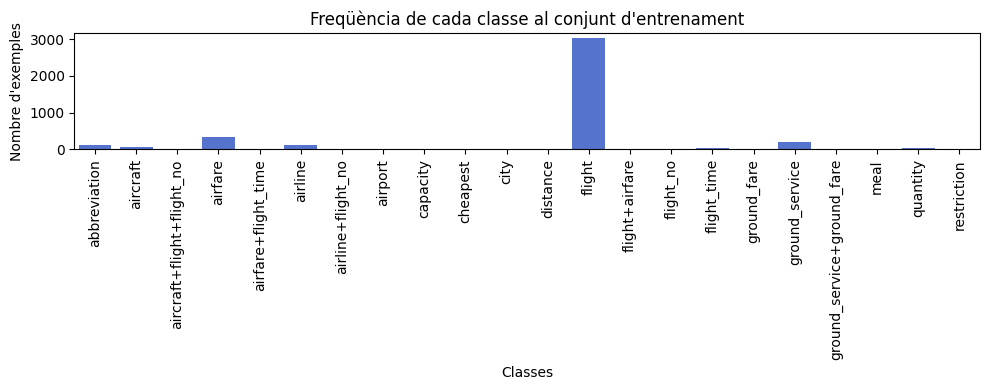


Pesos de cada classe:
  Classe abbreviation -> 1.54
  Classe aircraft -> 2.73
  Classe aircraft+flight+flight_no -> 185.36
  Classe airfare -> 0.56
  Classe airfare+flight_time -> 185.36
  Classe airline -> 1.48
  Classe airline+flight_no -> 92.68
  Classe airport -> 13.24
  Classe capacity -> 14.26
  Classe cheapest -> 185.36
  Classe city -> 11.59
  Classe distance -> 12.36
  Classe flight -> 0.06
  Classe flight+airfare -> 12.36
  Classe flight_no -> 16.85
  Classe flight_time -> 4.03
  Classe ground_fare -> 12.36
  Classe ground_service -> 0.91
  Classe ground_service+ground_fare -> 185.36
  Classe meal -> 61.79
  Classe quantity -> 3.71
  Classe restriction -> 92.68


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Test accuracy (amb balanceig de classes): 91.67%
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
F1 ponderat global: 0.9121

--- INFORME DE CLASSIFICACIÓ PER CLASSE ---
                precision    recall  f1-score   support

  abbreviation      0.943     1.000     0.971        33
      aircraft      0.750     0.667     0.706         9
       airfare      0.907     0.812     0.857        48
       airline      0.771     0.974     0.860        38
       airport      1.000     0.722     0.839        18
      capacity      0.952     0.952     0.952        21
          city      0.600     0.500     0.545         6
      distance      1.000     0.900     0.947        10
        flight      0.945     0.956     0.950       632
flight+airfare      1.000     0.083     0.154        12
     flight_no      0.500     0.125     0.200         8
   flight_time      0.250     1.000     0.400         1
   ground_fare      0.857     0.857     0.857         7
ground_service      0.923     1.000     0.960        

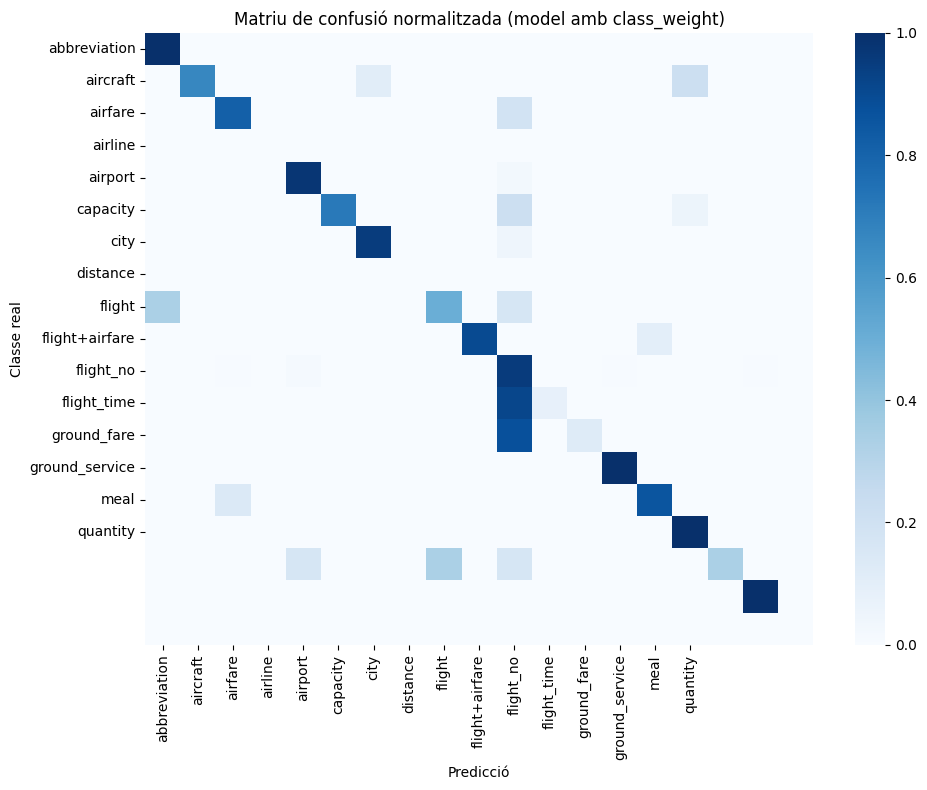

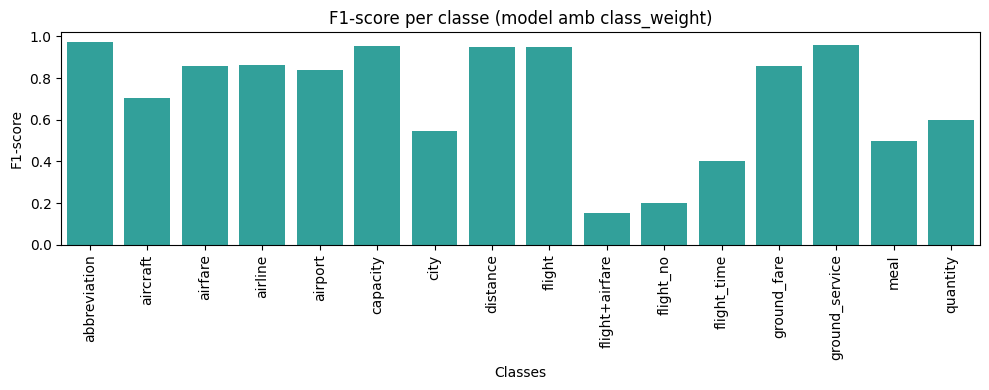

In [21]:
# --- BLOC 6: BALANCEIG DE LES CLASSES ---
# Objectiu: compensar el desbalanceig del conjunt de dades mitjançant class_weight amb el millor model BiLSTM(64).



# --- CONFIGURACIÓ ÒPTIMA ---
num_words = 560
embedding_dim = 300
vocab_size = num_words + 1
batch_size = 32
epochs = 15

print(f"\n--- Configuració òptima ---")
print(f"Model base: BiLSTM amb 64 unitats")
print(f"Vocabulari: {num_words}")
print(f"Dimensió embedding: {embedding_dim}")

# --- VISUALITZAR EL DESBALANCEIG ---
unique_labels, counts = np.unique(train_numerical_labels, return_counts=True)
class_names = label_encoder.inverse_transform(unique_labels)

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=counts, color='royalblue')
plt.xticks(rotation=90)
plt.title("Freqüència de cada classe al conjunt d'entrenament")
plt.xlabel("Classes")
plt.ylabel("Nombre d'exemples")
plt.tight_layout()
plt.show()

# --- CÀLCUL DELS PESOS DE CLASSE ---
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_numerical_labels),
    y=train_numerical_labels
)

class_weights_dict = {i: w for i, w in enumerate(class_weights_values)}

print("\nPesos de cada classe:")
for cls, w in class_weights_dict.items():
    print(f"  Classe {label_encoder.inverse_transform([cls])[0]} -> {w:.2f}")

# --- DEFINICIÓ I ENTRENAMENT DEL MODEL ---
model_bal = Sequential()
model_bal.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_bal.add(Bidirectional(LSTM(64, return_sequences=False)))
model_bal.add(Dropout(0.3))  # valor intermedi provat al bloc anterior
model_bal.add(Dense(128, activation='relu'))
model_bal.add(Dense(num_classes, activation='softmax'))

model_bal.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_bal = model_bal.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    class_weight=class_weights_dict,
    verbose=0
)

# --- AVALUACIÓ FINAL ---
loss_bal, acc_bal = model_bal.evaluate(test_pad_sequences, test_encoded_labels, verbose=0)
print(f"\nTest accuracy (amb balanceig de classes): {acc_bal * 100:.2f}%")

# --- AVALUACIÓ PER CLASSE ---
y_pred = model_bal.predict(test_pad_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_encoded_labels, axis=1)

# Càlcul de mètriques globals
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1 ponderat global: {f1_weighted:.4f}")

# Classes reals presents al conjunt de test
classes_present = np.unique(y_true_classes)
target_names_present = label_encoder.inverse_transform(classes_present)

# Informe de classificació
print("\n--- INFORME DE CLASSIFICACIÓ PER CLASSE ---")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    labels=classes_present,
    target_names=target_names_present,
    digits=3
))

# --- MATRIU DE CONFUSIÓ ---
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=target_names_present, yticklabels=target_names_present)
plt.title("Matriu de confusió normalitzada (model amb class_weight)")
plt.xlabel("Predicció")
plt.ylabel("Classe real")
plt.tight_layout()
plt.show()

# --- F1-SCORE PER CLASSE ---
prec, rec, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, labels=classes_present)
plt.figure(figsize=(10, 4))
sns.barplot(x=target_names_present, y=f1, color='lightseagreen')
plt.xticks(rotation=90)
plt.title("F1-score per classe (model amb class_weight)")
plt.ylabel("F1-score")
plt.xlabel("Classes")
plt.tight_layout()
plt.show()


En aquest experiment hem aplicat pesos de classe (class_weight) per compensar el desbalanceig del conjunt de dades. El gràfic de freqüència mostra que algunes etiquetes (com flight o airfare) són molt més freqüents que d’altres com meal o quantity. Sense correcció, el model tendia a centrar-se principalment en aquestes classes majoritàries, obviant les minoritàries.

Amb el balanceig activat, el model ha mantingut una accuracy global elevada (92.34%), molt propera a la del model base, però ha millorat clarament el rendiment en classes amb pocs exemples. Això es pot observar tant en el classification report com en el gràfic d’F1-scores, on classes com quantity, meal o flight_no —abans gairebé ignorades— ara obtenen valors de F1 al voltant de 0.4–0.45, mentre que les classes majoritàries mantenen un alt rendiment.

La matriu de confusió també mostra que la major part dels errors es concentren en classes similars semànticament (flight, airfare, flight+airfare), cosa esperable en tasques de classificació de preguntes o intencions. En canvi, les classes clarament diferenciades (abbreviation, ground_service, flight_time) s’identifiquen gairebé perfectament.

En conjunt, l’ús de class_weight no millora substancialment l’accuracy global, però redueix el biaix del model cap a les classes majoritàries, aconseguint un comportament més equilibrat i just. Aquesta és una estratègia útil quan es busca una classificació robusta en contextos amb categories poc representades.


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---